### 251103 중간고사 이후 작업

In [ ]:
msc_new <- NormalizeData(msc_new)
msc_new <- FindVariableFeatures(msc_new)
msc_new <- ScaleData(msc_new)
msc_new <- RunPCA(msc_new)
ElbowPlot(msc_new)

1:9가 elbowplot 상에서 가장 적당한 값. 일단 res 1.0으로 설정해서 그려보기.

In [ ]:
msc_new <- FindNeighbors(msc_new, dims = 1:9)
msc_new <- FindClusters(msc_new, resolution = 1.0)

msc_new <- RunUMAP(msc_new, dims = 1:9)
DimPlot(msc_new, reduction = "umap", label = TRUE, pt.size = 0.5)

png("UMAP_1103.png",  width = 1000, height = 800)
DimPlot(msc_new, reduction = "umap", label = TRUE, pt.size = 0.5)
dev.off()

너무 cluster 많아서 줄여서 시도

In [ ]:
library(Seurat)
library(ggplot2)
msc <- FindClusters(msc, resolution = 0.3)
msc <- RunUMAP(msc, dims = 1:9)
DimPlot(msc, reduction = "umap", label = TRUE, pt.size = 0.5)

cluster 6, 7 상위 유전자 확인하기

In [ ]:
# 클러스터 6
markers_6 <- FindMarkers(msc_new, ident.1 = 6, min.pct = 0.25, logfc.threshold = 0.25)
write.csv(markers_6, file = "markers_6.csv", row.names = FALSE)
# 여기까지 진행함 -1103

# 클러스터 7
markers_7 <- FindMarkers(msc_new, ident.1 = 7, min.pct = 0.25, logfc.threshold = 0.25)
write.csv(markers_7, file = "markers_7.csv", row.names = FALSE)

# 상위 유전자 확인
head(markers_6)
head(markers_7)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cldn1,0,7.874042,0.696,0.014,0
Klf5,0,6.478138,0.679,0.025,0
Itga6,0,6.454329,0.690,0.041,0
Wnt6,0,9.137828,0.643,0.006,0
Clec1a,0,5.592319,0.571,0.018,0
Itgb4,0,7.776330,0.542,0.023,0


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bglap2,0,8.555841,0.722,0.011,0
Htra4,0,8.147558,0.667,0.005,0
Col22a1,0,8.501556,0.667,0.005,0
Bglap,0,7.028837,0.578,0.010,0
Megf10,0,6.900791,0.544,0.007,0
Clic5,0,7.848021,0.456,0.005,0


In [ ]:
saveRDS(msc, "msc_251103.rds")

Marker 조사 결과 cluster 6은 endothelial이라고 판단 --> subset

In [ ]:
cells_to_keep <- WhichCells(msc, idents = setdiff(levels(msc), "6"))   # 6번 cluster 제외외
msc_wo_6 <- subset(msc, cells = cells_to_keep)
msc <- msc_wo_6

### Monocle3 로 trajectory pathway 그리기

In [ ]:

# Conda 환경 내의 R 버전을 변경하거나 재설치
conda install -c conda-forge r-base=<다른 버전>
install.packages("ggforce")

install.packages("devtools")
remotes::install_github("bnprks/BPCells/r")
devtools::install_github('cole-trapnell-lab/monocle3')
install.packages("ggforce")


install.packages("remotes")
remotes::install_github("cole-trapnell-lab/monocle3")
library(monocle3)
library(Seurat)
library(SeuratWrappers)

In [ ]:

cds <- as.cell_data_set(msc)  # msc_wo_6: 클러스터 6 제거한 Seurat 객체
cds <- cluster_cells(cds)  # cluster 정보 가져오기

cds <- learn_graph(cds)  # trajectory path 
cds <- order_cells(cds)  # 시작점을 자동으로 계산 ,pseudotime 계산
plot_cells(cds, color_cells_by = "pseudotime") 
msc$pseudotime <- cds@principal_graph_aux[["UMAP"]]$pseudotime
plot_cells(cds, color_cells_by = "seurat_clusters", label_groups_by_cluster = FALSE)



Monocle3 설치 안돼서 slingshot으로 다시 시도

### Slingshot으로 trajectory pathway 그리기

In [ ]:
BiocManager::install("slingshot")
BiocManager::install("SingleCellExperiment")

library(slingshot)
library(Seurat)
library(SingleCellExperiment)
library(ggplot2)

,Lineage1,Lineage2
GSM3589975_HODay0replicate1_AAACCTGAGAGAACAG-1,29.2801838,NA
GSM3589975_HODay0replicate1_AAACCTGGTCATGCAT-1,28.7790227,NA
GSM3589975_HODay0replicate1_AAACGGGAGGCCCGTT-1,26.6874497,NA
GSM3589975_HODay0replicate1_AAACGGGCAACTGGCC-1,0.8839277,0.9984353
GSM3589975_HODay0replicate1_AAACGGGTCAGCTGGC-1,3.4592219,NA
GSM3589975_HODay0replicate1_AAACGGGTCCGTACAA-1,NA,27.7743948


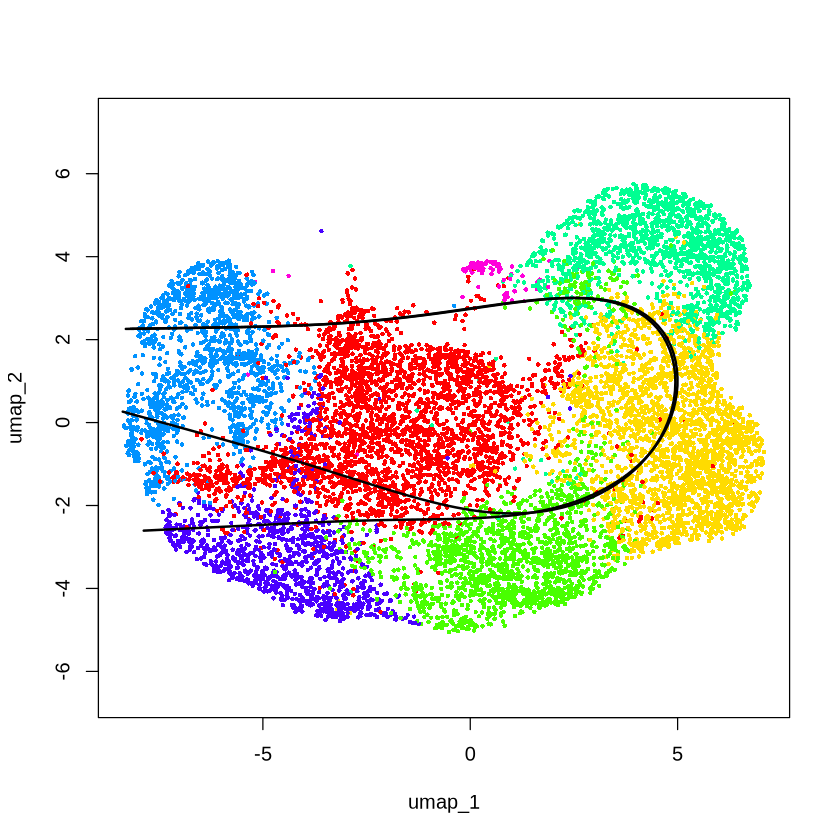

In [ ]:
library(slingshot)
library(Seurat)
library(SingleCellExperiment)
library(ggplot2)

# 1. UMAP, cluster, data 추출
umap <- Seurat::Embeddings(msc, "umap")
clust <- Seurat::Idents(msc)
logcounts_matrix <- Seurat::GetAssayData(msc, assay = "RNA", slot = "data")

# 2. SCE 객체 만들기
library(SingleCellExperiment)
sce <- SingleCellExperiment(assays = list(logcounts = logcounts_matrix))
reducedDims(sce) <- SimpleList(UMAP = umap)
colData(sce)$cluster <- clust  # 이게 slingshot의 clusterLabels

# 3. Slingshot 수행
library(slingshot)
sce <- slingshot(sce, clusterLabels = 'cluster', reducedDim = 'UMAP')

# 4. pseudotime 추출
pseudotime <- slingPseudotime(sce)
head(pseudotime)

# 5. 시각화
plot(reducedDims(sce)$UMAP,
     col = rainbow(length(unique(clust)))[as.numeric(clust)],
     pch = 16, asp = 1, cex = 0.5)
lines(SlingshotDataSet(sce), lwd = 2)



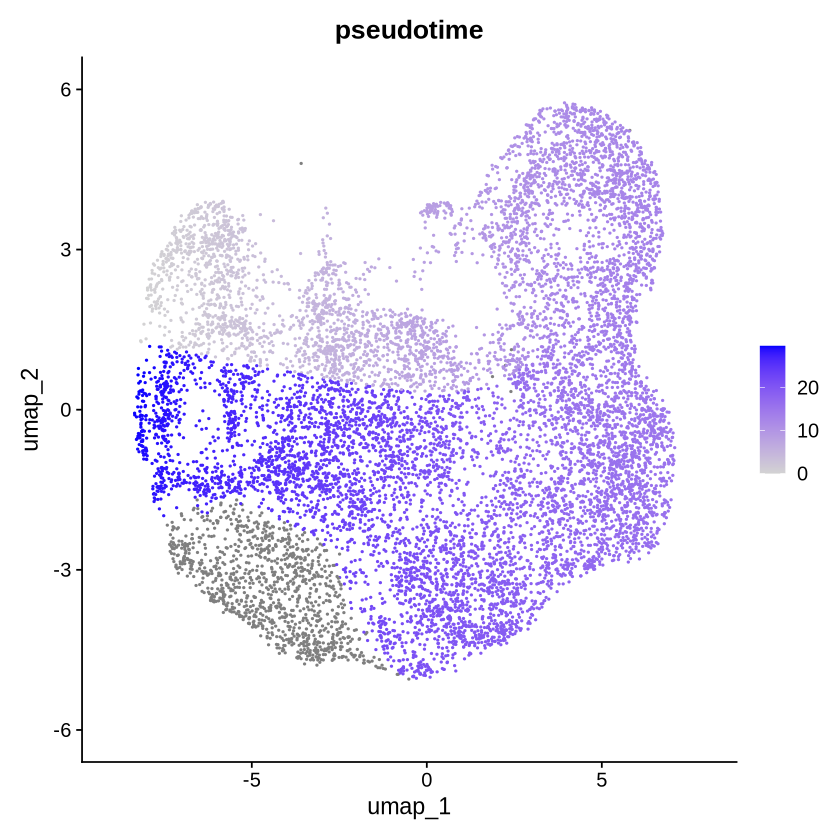

In [ ]:
# trajectory pathway pseudotime으로 확인
msc$pseudotime <- slingPseudotime(sce)[, 1]
FeaturePlot(msc, "pseudotime", reduction = "umap")

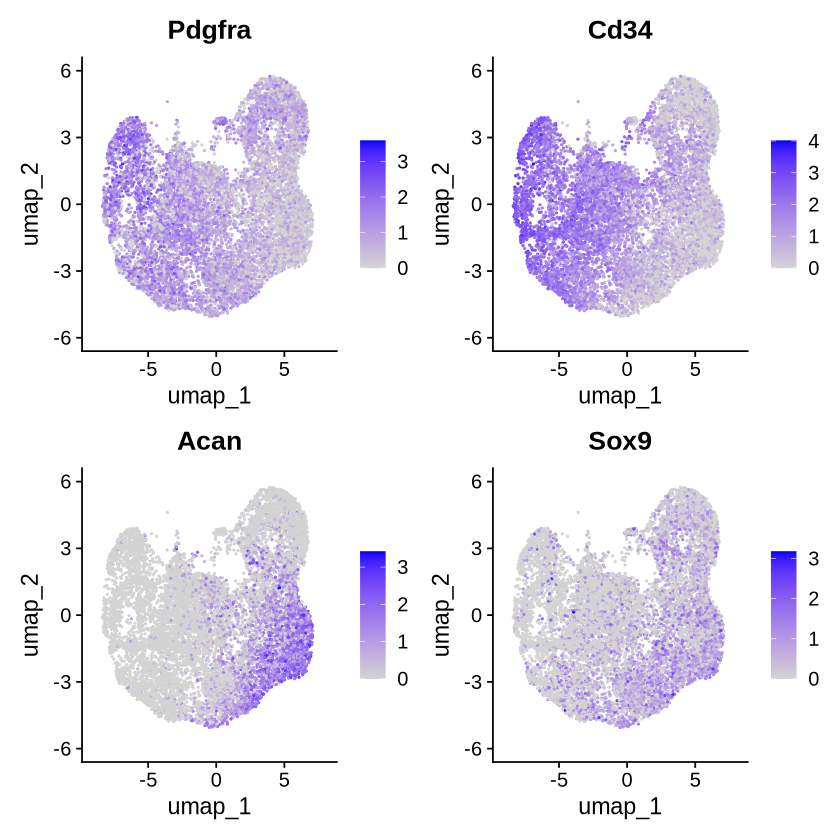

In [ ]:
FeaturePlot(msc, features = c("Pdgfra", "Cd34", "Acan", "Sox9"), reduction = "umap", ncol = 2)


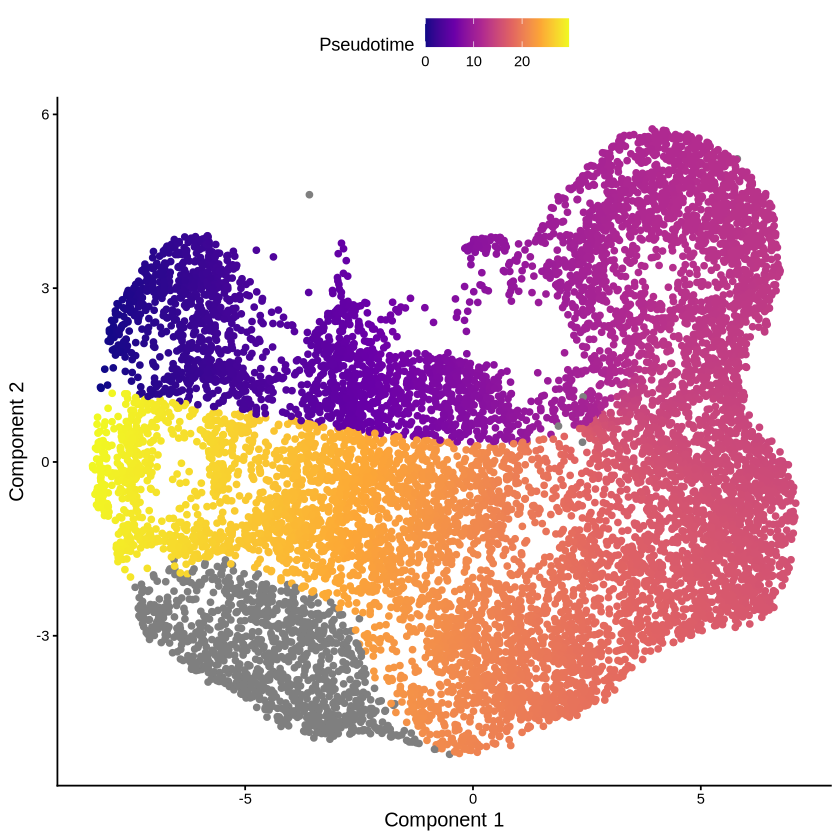

In [ ]:
# 1. Slingshot으로 생성한 SCE 객체에서 UMAP 좌표와 pseudotime 가져오기
umap_df <- as.data.frame(reducedDims(sce)$UMAP)  # UMAP 좌표
pseudotime <- slingPseudotime(sce)[, 1]  # 첫 번째 lineage 기준

# 2. 데이터 프레임으로 합치기
plot_df <- data.frame(
  UMAP1 = umap_df[, 1],
  UMAP2 = umap_df[, 2],
  pseudotime = pseudotime
)

# 3. pseudotime 값을 색으로 표현
ggplot(plot_df, aes(x = UMAP1, y = UMAP2, color = pseudotime)) +
  geom_point(size = 1.5) +
  scale_color_viridis_c(option = "C") +
  theme_classic() +
  theme(
    axis.title = element_text(size = 12),
    legend.position = "top"
  ) +
  labs(x = "Component 1", y = "Component 2", color = "Pseudotime")

In [ ]:
install.packages("phateR")
library(phateR)
library(Seurat)
library(BiocManager)
library(ggplot2)
library(SingleCellExperiment)
library(slingshot)

### Phate

phate를 현재 파이썬 버전에서 못해서 새로운 콘다 환경 만들어서 진행

In [ ]:
conda create -n phate_env python=3.10
conda activate phate_env
pip install --upgrade pip setuptools wheel build
pip install phate

library(reticulate)

# 원하는 conda 환경 명시 (phate_env 경로로 정확히 지정하거나 이름만 입력)
use_condaenv("phate_env", required = TRUE)


In [ ]:
# 2. 데이터 준비
counts <- as.matrix(GetAssayData(msc, assay = "RNA", slot = "data"))
hvg <- VariableFeatures(msc)
counts_hvg <- counts[hvg, ]

# 3. PHATE
phate_result <- phate(counts_hvg)

# 4. cluster 정보
clust <- Idents(msc)

# 5. SCE 만들기
sce <- SingleCellExperiment(
    assays = List(counts = counts_hvg),
    reducedDims = SimpleList(PHATE = phate_result$embedding),
    colData = DataFrame(cluster = clust)
)

# 6. Slingshot
sce <- slingshot(sce, clusterLabels = 'cluster', reducedDim = 'PHATE')
pseudotime <- slingPseudotime(sce)

# 7. 시각화
colors <- viridis::viridis(100)[cut(pseudotime[,1], breaks=100)]
plot(reducedDims(sce)$PHATE, col = colors, pch = 16, asp = 1)
lines(SlingshotDataSet(sce), lwd = 2)

In [ ]:
saveRDS(msc, "msc_251105.rds")